
Transfer Learning Tutorial
==========================
**Author**: `Sasank Chilamkurthy <https://chsasank.github.io>`_

In this tutorial, you will learn how to train your network using
transfer learning. You can read more about the transfer learning at `cs231n
notes <http://cs231n.github.io/transfer-learning/>`__

Quoting these notes,

    In practice, very few people train an entire Convolutional Network
    from scratch (with random initialization), because it is relatively
    rare to have a dataset of sufficient size. Instead, it is common to
    pretrain a ConvNet on a very large dataset (e.g. ImageNet, which
    contains 1.2 million images with 1000 categories), and then use the
    ConvNet either as an initialization or a fixed feature extractor for
    the task of interest.

These two major transfer learning scenarios look as follows:

-  **Finetuning the convnet**: Instead of random initializaion, we
   initialize the network with a pretrained network, like the one that is
   trained on imagenet 1000 dataset. Rest of the training looks as
   usual.
-  **ConvNet as fixed feature extractor**: Here, we will freeze the weights
   for all of the network except that of the final fully connected
   layer. This last fully connected layer is replaced with a new one
   with random weights and only this layer is trained.




In [0]:
%matplotlib inline

# License: BSD
# Author: Sasank Chilamkurthy

from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

plt.ion()   # interactive mode

In [0]:
print(torch.cuda.is_available())
print(torch.cuda.current_device())
!nvidia-smi

True
0
Sat Sep  7 13:28:48 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 430.40       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   55C    P0    59W / 149W |    673MiB / 11441MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|

Load Data
---------

We will use torchvision and torch.utils.data packages for loading the
data.

The problem we're going to solve today is to train a model to classify
**ants** and **bees**. We have about 120 training images each for ants and bees.
There are 75 validation images for each class. Usually, this is a very
small dataset to generalize upon, if trained from scratch. Since we
are using transfer learning, we should be able to generalize reasonably
well.

This dataset is a very small subset of imagenet.

.. Note ::
   Download the data from
   `here <https://download.pytorch.org/tutorial/hymenoptera_data.zip>`_
   and extract it to the current directory.



In [0]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:

!unzip "drive/My Drive/Colab Notebooks/torch/dest77.zip"
data_dir ='dest7'

# !curl https://download.pytorch.org/tutorial/hymenoptera_data.zip --output hymenoptera_data.zip
# !unzip hymenoptera_data.zip
# data_dir = "hymenoptera_data"


Archive:  drive/My Drive/Colab Notebooks/torch/dest77.zip
   creating: dest7/
   creating: dest7/train/
   creating: dest7/train/goo/
  inflating: dest7/train/goo/goo_20190907_203547.jpg  
  inflating: dest7/train/goo/goo_20190907_203553.jpg  
  inflating: dest7/train/goo/goo_20190907_203552.jpg  
  inflating: dest7/train/goo/goo_20190907_203546.jpg  
  inflating: dest7/train/goo/goo_20190907_203550.jpg  
  inflating: dest7/train/goo/goo_20190907_203545.jpg  
  inflating: dest7/train/goo/goo_20190907_203551.jpg  
  inflating: dest7/train/goo/goo_20190907_203555.jpg  
  inflating: dest7/train/goo/goo_20190907_203554.jpg  
  inflating: dest7/train/goo/goo_20190907_203556.jpg  
  inflating: dest7/train/goo/goo_20190907_203557.jpg  
  inflating: dest7/train/goo/goo_20190907_203524.jpg  
  inflating: dest7/train/goo/goo_20190907_203525.jpg  
  inflating: dest7/train/goo/goo_20190907_203522.jpg  
  inflating: dest7/train/goo/goo_20190907_203521.jpg  
  inflating: dest7/train/goo/goo_20190907

In [0]:
# !ls dest7/train/goo | sed 's/.jpg//g' | awk '{print "dest7/train/goo/" $1 ".jpg " "dest7/train/goo/" $1 "_2.jpg"}'  | xargs -n 2 cp
# !ls dest7/train/choki | sed 's/.jpg//g' | awk '{print "dest7/train/choki/" $1 ".jpg " "dest7/train/choki/" $1 "_2.jpg"}'  | xargs -n 2 cp
# !ls dest7/train/paa | sed 's/.jpg//g' | awk '{print "dest7/train/paa/" $1 ".jpg " "dest7/train/paa/" $1 "_2.jpg"}'  | xargs -n 2 cp
# !ls dest7/train/goo | sed 's/.jpg//g' | awk '{print "dest7/train/goo/" $1 ".jpg " "dest7/train/goo/" $1 "_3.jpg"}'  | xargs -n 2 cp
# !ls dest7/train/goo | sed 's/.jpg//g' | awk '{print "dest7/train/goo/" $1 ".jpg " "dest7/train/goo/" $1 "_4.jpg"}'  | xargs -n 2 cp

# !ls dest7/train/goo | sed 's/.jpg//g' | awk '{print "dest7/train/goo/" $1 ".jpg " "dest7/train/goo/" $1 "_5.jpg"}'  | xargs -n 2 cp

# !ls dest7/train/goo | sed 's/.jpg//g' | awk '{print "dest7/train/goo/" $1 ".jpg " "dest7/train/goo/" $1 "_6.jpg"}'  | xargs -n 2 cp

# !ls dest7/train/goo | sed 's/.jpg//g' | awk '{print "dest7/train/goo/" $1 ".jpg " "dest7/train/goo/" $1 "_7.jpg"}'  | xargs -n 2 cp

# !ls dest7/train/goo | sed 's/.jpg//g' | awk '{print "dest7/train/goo/" $1 ".jpg " "dest7/train/goo/" $1 "_8.jpg"}'  | xargs -n 2 cp

# !ls dest7/train/goo | sed 's/.jpg//g' | awk '{print "dest7/train/goo/" $1 ".jpg " "dest7/train/goo/" $1 "_9.jpg"}'  | xargs -n 2 cp

# !ls dest7/train/goo | sed 's/.jpg//g' | awk '{print "dest7/train/goo/" $1 ".jpg " "dest7/train/goo/" $1 "_10.jpg"}'  | xargs -n 2 cp





In [0]:
# goo = 0
# choki = 2
# paa = 5

!git clone https://github.com/ardamavi/Sign-Language-Digits-Dataset.git
!ls -d Sign-Language-Digits-Dataset/Dataset/0/*  | awk '{print  $1 " "  "dest7/train/goo/" }'  | xargs -n 2 mv
!ls -d Sign-Language-Digits-Dataset/Dataset/2/*  | awk '{print  $1 " "  "dest7/train/choki/" }'  | xargs -n 2 mv
!ls -d Sign-Language-Digits-Dataset/Dataset/5/*  | awk '{print  $1 " "  "dest7/train/paa/" }'  | xargs -n 2 mv

!ls -d dest7/train/goo/* | grep "IMG*" | head -n 50 | awk '{print $1 " " "dest7/val/goo/" }' | xargs -n 2 mv
!ls -d dest7/train/choki/* | grep "IMG*" | head -n 50 | awk '{print $1 " " "dest7/val/choki/" }' | xargs -n 2 mv
!ls -d dest7/train/paa/* | grep "IMG*" | head -n 50 | awk '{print $1 " " "dest7/val/paa/" }' | xargs -n 2 mv

In [0]:
!ls  dest7/train/goo

goo_20190907_203520.jpg  IMG_4059.JPG  IMG_4554.JPG  IMG_5053.JPG  IMG_5547.JPG
goo_20190907_203521.jpg  IMG_4069.JPG  IMG_4564.JPG  IMG_5063.JPG  IMG_5562.JPG
goo_20190907_203522.jpg  IMG_4079.JPG  IMG_4574.JPG  IMG_5074.JPG  IMG_5572.JPG
goo_20190907_203524.jpg  IMG_4089.JPG  IMG_4584.JPG  IMG_5091.JPG  IMG_5582.JPG
goo_20190907_203525.jpg  IMG_4099.JPG  IMG_4594.JPG  IMG_5101.JPG  IMG_5592.JPG
goo_20190907_203545.jpg  IMG_4109.JPG  IMG_4604.JPG  IMG_5111.JPG  IMG_5603.JPG
goo_20190907_203546.jpg  IMG_4119.JPG  IMG_4614.JPG  IMG_5122.JPG  IMG_5615.JPG
goo_20190907_203547.jpg  IMG_4129.JPG  IMG_4624.JPG  IMG_5132.JPG  IMG_5625.JPG
goo_20190907_203549.jpg  IMG_4139.JPG  IMG_4634.JPG  IMG_5142.JPG  IMG_5635.JPG
goo_20190907_203550.jpg  IMG_4149.JPG  IMG_4644.JPG  IMG_5152.JPG  IMG_5645.JPG
goo_20190907_203551.jpg  IMG_4159.JPG  IMG_4674.JPG  IMG_5163.JPG  IMG_5655.JPG
goo_20190907_203552.jpg  IMG_4170.JPG  IMG_4684.JPG  IMG_5173.JPG  IMG_5665.JPG
goo_20190907_203553.jpg  IMG_4181.JPG  I

In [0]:

# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.RandomGrayscale(),
        transforms.RandomRotation(30),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
class_names, device, dataset_sizes

(['choki', 'goo', 'paa'],
 device(type='cuda', index=0),
 {'train': 548, 'val': 229})

In [0]:
hoge = list(dataloaders['train'])
for x in hoge:
  print(x[0].shape)

hoge = list(dataloaders['val'])
for x in hoge:
  print(x[0].shape)
  


torch.Size([4, 3, 224, 224])
torch.Size([4, 3, 224, 224])
torch.Size([4, 3, 224, 224])
torch.Size([4, 3, 224, 224])
torch.Size([4, 3, 224, 224])
torch.Size([4, 3, 224, 224])
torch.Size([4, 3, 224, 224])
torch.Size([4, 3, 224, 224])
torch.Size([4, 3, 224, 224])
torch.Size([4, 3, 224, 224])
torch.Size([4, 3, 224, 224])
torch.Size([4, 3, 224, 224])
torch.Size([4, 3, 224, 224])
torch.Size([4, 3, 224, 224])
torch.Size([4, 3, 224, 224])
torch.Size([4, 3, 224, 224])
torch.Size([4, 3, 224, 224])
torch.Size([4, 3, 224, 224])
torch.Size([4, 3, 224, 224])
torch.Size([4, 3, 224, 224])
torch.Size([4, 3, 224, 224])
torch.Size([4, 3, 224, 224])
torch.Size([4, 3, 224, 224])
torch.Size([4, 3, 224, 224])
torch.Size([4, 3, 224, 224])
torch.Size([4, 3, 224, 224])
torch.Size([4, 3, 224, 224])
torch.Size([4, 3, 224, 224])
torch.Size([4, 3, 224, 224])
torch.Size([4, 3, 224, 224])
torch.Size([4, 3, 224, 224])
torch.Size([4, 3, 224, 224])
torch.Size([4, 3, 224, 224])
torch.Size([4, 3, 224, 224])
torch.Size([4,

Visualize a few images
^^^^^^^^^^^^^^^^^^^^^^
Let's visualize a few training images so as to understand the data
augmentations.



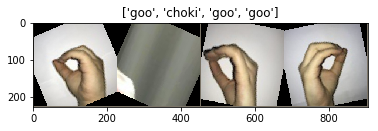

In [0]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

Training the model
------------------

Now, let's write a general function to train a model. Here, we will
illustrate:

-  Scheduling the learning rate
-  Saving the best model

In the following, parameter ``scheduler`` is an LR scheduler object from
``torch.optim.lr_scheduler``.



In [0]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()



    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                scheduler.step()
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

Visualizing the model predictions
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

Generic function to display predictions for a few images




In [0]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [0]:
!rm -r ~/.cache/torch

In [40]:
visualize_model(model_ft)

NameError: ignored

ConvNet as fixed feature extractor
----------------------------------

Here, we need to freeze all the network except the final layer. We need
to set ``requires_grad == False`` to freeze the parameters so that the
gradients are not computed in ``backward()``.

You can read more about this in the documentation
`here <http://pytorch.org/docs/notes/autograd.html#excluding-subgraphs-from-backward>`__.




In [0]:
%time
# model_conv = torchvision.models.resnet18(pretrained=True)
model_conv = torchvision.models.resnet50(pretrained=True)

# resnet50の特徴をそのまま使うためにbackwardをoff
for param in model_conv.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, len(class_names))

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opoosed to before.
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

CPU times: user 3 µs, sys: 1e+03 ns, total: 4 µs
Wall time: 8.82 µs


Train and evaluate
^^^^^^^^^^^^^^^^^^

On CPU this will take about half the time compared to previous scenario.
This is expected as gradients don't need to be computed for most of the
network. However, forward does need to be computed.




In [0]:
%time
model_conv = train_model(model_conv, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=25)

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 8.58 µs
Epoch 0/24
----------
train Loss: 0.9286 Acc: 0.5821
val Loss: 0.9810 Acc: 0.3886

Epoch 1/24
----------
train Loss: 0.7413 Acc: 0.6989
val Loss: 0.5120 Acc: 0.7686

Epoch 2/24
----------
train Loss: 0.6948 Acc: 0.7153
val Loss: 0.4391 Acc: 0.8384

Epoch 3/24
----------
train Loss: 0.6994 Acc: 0.6989
val Loss: 0.4554 Acc: 0.8603

Epoch 4/24
----------
train Loss: 0.6394 Acc: 0.7318
val Loss: 0.4305 Acc: 0.8515

Epoch 5/24
----------
train Loss: 0.6564 Acc: 0.7245
val Loss: 0.5124 Acc: 0.7642

Epoch 6/24
----------
train Loss: 0.5167 Acc: 0.7737
val Loss: 0.3818 Acc: 0.8472

Epoch 7/24
----------
train Loss: 0.5057 Acc: 0.7828
val Loss: 0.4533 Acc: 0.7860

Epoch 8/24
----------
train Loss: 0.5477 Acc: 0.7774
val Loss: 0.4089 Acc: 0.8253

Epoch 9/24
----------
train Loss: 0.5237 Acc: 0.7938
val Loss: 0.3559 Acc: 0.8603

Epoch 10/24
----------
train Loss: 0.4946 Acc: 0.7865
val Loss: 0.3830 Acc: 0.8384

Epoch 11/24
----------

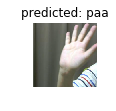

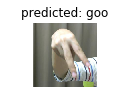

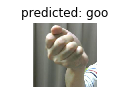

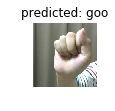

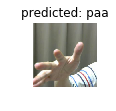

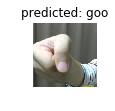

In [0]:
visualize_model(model_conv)

plt.ioff()
plt.show()

In [0]:
!curl https://www.photolibrary.jp/mhd7/img375/450-20141229110838146588.jpg -o choki.jpg
# !curl https://d1f5hsy4d47upe.cloudfront.net/88/887266c428f2361d9f273cc8d4e86494_t.jpeg -o goo.jpg

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 38378  100 38378    0     0  17916      0  0:00:02  0:00:02 --:--:-- 17916


In [0]:
# torch.save(model_conv.state_dict(), "drive/My Drive/Colab Notebooks/model.dat")
!ls "drive/My Drive/Colab Notebooks/"

 iida	      model.dat   transfer_learning_janken.ipynb
 iida.ipynb   torch	 'transfer_learning_tutorial.ipynb のコピー'


In [0]:
%time
from PIL import Image

data_transform = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])

image = Image.open('choki.jpg')

image = data_transform(image).unsqueeze(0).cuda()

model_conv.eval()
out = model_conv(image)
# Find the predicted class
print("Predicted class is: {}".format(class_names[out.argmax()]))

CPU times: user 1e+03 ns, sys: 1e+03 ns, total: 2 µs
Wall time: 5.72 µs
Predicted class is: choki


In [0]:
torch.save(model_conv.state_dict(), "drive/My Drive/Colab Notebooks/resnet50_5.dat")

In [0]:
!ls dest7/train

In [0]:
from PIL import Image


model_path = "drive/My Drive/Colab Notebooks/resnet50_5.dat"
class_num = len(class_names)
def init_model():
    model_conv = torchvision.models.resnet50()
    for param in model_conv.parameters():
        param.requires_grad = False
        
    num_ftrs = model_conv.fc.in_features
    model_conv.fc = nn.Linear(num_ftrs, class_num)

    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    print(device)
    model_conv = model_conv.to(device)
    print("start loading")
    model_conv.load_state_dict(torch.load(model_path))
    print("finish loading")
    model_conv.eval()
    return model_conv
  
def predict(image, model):
    # model_conv = init_model()
    data_transform = transforms.Compose([
            transforms.Resize(256),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])

    image = data_transform(image).unsqueeze(0).cuda()
    print("start predicting")
    out = model(image)
    print("finish predicting", out.argmax())
    print(out, out.argmax())
    class_name = class_names[out.argmax()]
    print("Predicted class is: {}".format(class_name))
    return class_name

model_conv2 =  init_model()

image = Image.open('choki.jpg')
predict(image, model_conv2)

image = Image.open('goo.jpg')
predict(image, model_conv2)

cuda:0
start loading
finish loading
start predicting
finish predicting tensor(0, device='cuda:0')
tensor([[ 0.1782, -0.3271, -0.1551]], device='cuda:0', grad_fn=<AddmmBackward>) tensor(0, device='cuda:0')
Predicted class is: choki
start predicting
finish predicting tensor(0, device='cuda:0')
tensor([[ 0.1460, -0.2026, -0.3004]], device='cuda:0', grad_fn=<AddmmBackward>) tensor(0, device='cuda:0')
Predicted class is: choki


'choki'